In [1]:
import re  # for regular expressions 
import nltk # for text manipulation 
import string
import warnings
import numpy as np
import pandas as pd

from nltk.stem import WordNetLemmatizer #word stemmer class
lemma = WordNetLemmatizer()
from nltk import FreqDist
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from textblob import TextBlob
%matplotlib inline

pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore", category=DeprecationWarning)

from IPython.display import display
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
lem = WordNetLemmatizer()

from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import RegexpTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
Data = pd.read_csv('/content/drive/MyDrive/Datasets/Hatespeech/trump.csv', index_col=[0])

display(Data.head(5))

,id,script
0,0,"\n\t\n\t\t\n\t\t\n\t\t\t\t\n\t\t\tDonald Trump: (00:13)\nHello, Iowa. Congratulations to the Iowa hawkers. That was a big win today. I’m thrilled to be back. That was a big win. But I am thrilled ..."
1,1,"\n\t\n\t\t\n\t\t\n\t\t\t\t\n\t\t\tDonald Trump: (03:37)\nWe have great, great people running. Many of them are right here. I love Marjorie. With your help, we’re going to take back the House and s..."
2,2,\n\t\n\t\t\n\t\t\n\t\t\t\t\n\t\t\tGreg Gutfeld: (00:05)\nAll right. Why should I say a thing? Let’s just get to round two. I want to ask you a question about COVID because you had COVID and my wif...
3,3,"\n\t\n\t\t\n\t\t\n\t\t\t\t\n\t\t\tDonald Trump: (00:00)\nAs one nation, America mourns the loss of our brave and brilliant American service members in a savage and barbaric terrorist attack in Afg..."
4,4,"\n\t\n\t\t\n\t\t\n\t\t\t\t\n\t\t\tDonald Trump: (08:53)\nThank you. Thank you. Wow, this is a big crowd. I’ll tell you. This goes all the way back. I wish they’d show it because they just don’t do..."


In [4]:
display(Data.shape)
display(Data.info())

(12, 2)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12 entries, 0 to 11
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      12 non-null     int64 
 1   script  12 non-null     object
dtypes: int64(1), object(1)
memory usage: 288.0+ bytes


None

# Data Cleaning

### Removing \\n and \\t

In [5]:
# This function will look inside the "input text" and replace the pattern with '' if found.
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
    return input_txt

In [6]:
Data['tidy_script'] = np.vectorize(remove_pattern)(Data['script'], "\\t")
Data.head()

,id,script,tidy_script
0,0,"\n\t\n\t\t\n\t\t\n\t\t\t\t\n\t\t\tDonald Trump: (00:13)\nHello, Iowa. Congratulations to the Iowa hawkers. That was a big win today. I’m thrilled to be back. That was a big win. But I am thrilled ...","\n\n\n\n\nDonald Trump: (00:13)\nHello, Iowa. Congratulations to the Iowa hawkers. That was a big win today. I’m thrilled to be back. That was a big win. But I am thrilled to be back especially on..."
1,1,"\n\t\n\t\t\n\t\t\n\t\t\t\t\n\t\t\tDonald Trump: (03:37)\nWe have great, great people running. Many of them are right here. I love Marjorie. With your help, we’re going to take back the House and s...","\n\n\n\n\nDonald Trump: (03:37)\nWe have great, great people running. Many of them are right here. I love Marjorie. With your help, we’re going to take back the House and send Nancy Pelosi back to..."
2,2,\n\t\n\t\t\n\t\t\n\t\t\t\t\n\t\t\tGreg Gutfeld: (00:05)\nAll right. Why should I say a thing? Let’s just get to round two. I want to ask you a question about COVID because you had COVID and my wif...,"\n\n\n\n\nGreg Gutfeld: (00:05)\nAll right. Why should I say a thing? Let’s just get to round two. I want to ask you a question about COVID because you had COVID and my wife, you met my wife, I do..."
3,3,"\n\t\n\t\t\n\t\t\n\t\t\t\t\n\t\t\tDonald Trump: (00:00)\nAs one nation, America mourns the loss of our brave and brilliant American service members in a savage and barbaric terrorist attack in Afg...","\n\n\n\n\nDonald Trump: (00:00)\nAs one nation, America mourns the loss of our brave and brilliant American service members in a savage and barbaric terrorist attack in Afghanistan. These noble Am..."
4,4,"\n\t\n\t\t\n\t\t\n\t\t\t\t\n\t\t\tDonald Trump: (08:53)\nThank you. Thank you. Wow, this is a big crowd. I’ll tell you. This goes all the way back. I wish they’d show it because they just don’t do...","\n\n\n\n\nDonald Trump: (08:53)\nThank you. Thank you. Wow, this is a big crowd. I’ll tell you. This goes all the way back. I wish they’d show it because they just don’t do that. They don’t like… ..."


In [7]:
Data['tidy_script'] = np.vectorize(remove_pattern)(Data['tidy_script'], "\\n")
Data.head()

,id,script,tidy_script
0,0,"\n\t\n\t\t\n\t\t\n\t\t\t\t\n\t\t\tDonald Trump: (00:13)\nHello, Iowa. Congratulations to the Iowa hawkers. That was a big win today. I’m thrilled to be back. That was a big win. But I am thrilled ...","Donald Trump: (00:13)Hello, Iowa. Congratulations to the Iowa hawkers. That was a big win today. I’m thrilled to be back. That was a big win. But I am thrilled to be back especially on such great ..."
1,1,"\n\t\n\t\t\n\t\t\n\t\t\t\t\n\t\t\tDonald Trump: (03:37)\nWe have great, great people running. Many of them are right here. I love Marjorie. With your help, we’re going to take back the House and s...","Donald Trump: (03:37)We have great, great people running. Many of them are right here. I love Marjorie. With your help, we’re going to take back the House and send Nancy Pelosi back to San Francis..."
2,2,\n\t\n\t\t\n\t\t\n\t\t\t\t\n\t\t\tGreg Gutfeld: (00:05)\nAll right. Why should I say a thing? Let’s just get to round two. I want to ask you a question about COVID because you had COVID and my wif...,"Greg Gutfeld: (00:05)All right. Why should I say a thing? Let’s just get to round two. I want to ask you a question about COVID because you had COVID and my wife, you met my wife, I don’t know, it..."
3,3,"\n\t\n\t\t\n\t\t\n\t\t\t\t\n\t\t\tDonald Trump: (00:00)\nAs one nation, America mourns the loss of our brave and brilliant American service members in a savage and barbaric terrorist attack in Afg...","Donald Trump: (00:00)As one nation, America mourns the loss of our brave and brilliant American service members in a savage and barbaric terrorist attack in Afghanistan. These noble American warri..."
4,4,"\n\t\n\t\t\n\t\t\n\t\t\t\t\n\t\t\tDonald Trump: (08:53)\nThank you. Thank you. Wow, this is a big crowd. I’ll tell you. This goes all the way back. I wish they’d show it because they just don’t do...","Donald Trump: (08:53)Thank you. Thank you. Wow, this is a big crowd. I’ll tell you. This goes all the way back. I wish they’d show it because they just don’t do that. They don’t like… This goes al..."


### Expand contractions
To do that, first we create a dictionary with all the possible contractions

In [8]:
contractions_dict = {
        'didn\'t': 'did not',
        'don\'t': 'do not',
        "can't": "cannot",
        "can't've": "cannot have",
        "'cause": "because",
        "could've": "could have",
        "couldn't": "could not",
        "couldn't've": "could not have",
        "didn't": "did not",
        "doesn't": "does not",
        "don't": "do not",
        "hadn't": "had not",
        "hadn't've": "had not have",
        "hasn't": "has not",
        "haven't": "have not",
        "he'd": "he had / he would",
        "he'd've": "he would have",
        "he'll": "he shall / he will",
        "he'll've": "he shall have / he will have",
        "he's": "he has / he is",
        "how'd": "how did",
        "how'd'y": "how do you",
        "how'll": "how will",
        "how's": "how has / how is / how does",
        "I'd": "I had / I would",
        "I'd've": "I would have",
        "I'll": "I shall / I will",
        "I'll've": "I shall have / I will have",
        "I'm": "I am",
        "I've": "I have",
        "isn't": "is not",
        "it'd": "it had / it would",
        "it'd've": "it would have",
        "it'll": "it shall / it will",
        "it'll've": "it shall have / it will have",
        "it's": "it has / it is",
        "let's": "let us",
        "ma'am": "madam",
        "mayn't": "may not",
        "might've": "might have",
        "mightn't": "might not",
        "mightn't've": "might not have",
        "must've": "must have",
        "mustn't": "must not",
        "mustn't've": "must not have",
        "needn't": "need not",
        "needn't've": "need not have",
        "o'clock": "of the clock",
        "oughtn't": "ought not",
        "oughtn't've": "ought not have",
        "shan't": "shall not",
        "sha'n't": "shall not",
        "shan't've": "shall not have",
        "she'd": "she had / she would",
        "she'd've": "she would have",
        "she'll": "she shall / she will",
        "she'll've": "she shall have / she will have",
        "she's": "she has / she is",
        "should've": "should have",
        "shouldn't": "should not",
        "shouldn't've": "should not have",
        "so've": "so have",
        "so's": "so as / so is",
        "that'd": "that would / that had",
        "that'd've": "that would have",
        "that's": "that has / that is",
        "there'd": "there had / there would",
        "there'd've": "there would have",
        "there's": "there has / there is",
        "they'd": "they had / they would",
        "they'd've": "they would have",
        "they'll": "they shall / they will",
        "they'll've": "they shall have / they will have",
        "they're": "they are",
        "they've": "they have",
        "to've": "to have",
        "wasn't": "was not",
        "we'd": "we had / we would",
        "we'd've": "we would have",
        "we'll": "we will",
        "we'll've": "we will have",
        "we're": "we are",
        "we've": "we have",
        "weren't": "were not",
        "what'll": "what shall / what will",
        "what'll've": "what shall have / what will have",
        "what're": "what are",
        "what's": "what has / what is",
        "what've": "what have",
        "when's": "when has / when is",
        "when've": "when have",
        "where'd": "where did",
        "where's": "where has / where is",
        "where've": "where have",
        "who'll": "who shall / who will",
        "who'll've": "who shall have / who will have",
        "who's": "who has / who is",
        "who've": "who have",
        "why's": "why has / why is",
        "why've": "why have",
        "will've": "will have",
        "won't": "will not",
        "won't've": "will not have",
        "would've": "would have",
        "wouldn't": "would not",
        "wouldn't've": "would not have",
        "y'all": "you all",
        "y'all'd": "you all would",
        "y'all'd've": "you all would have",
        "y'all're": "you all are",
        "y'all've": "you all have",
        "you'd": "you had / you would",
        "you'd've": "you would have",
        "you'll": "you shall / you will",
        "you'll've": "you shall have / you will have",
        "you're": "you are",
        "you've": "you have"
}

contractions_re = re.compile('(%s)' % '|'.join(contractions_dict.keys()))

Then we use this function to detect contractions in the text and expand them

In [9]:
def expand_contractions(s, contractions_dict=contractions_dict):
     def replace(match):
         return contractions_dict[match.group(0)]
     return contractions_re.sub(replace, s)

In [10]:
Data['tidy_script'] = Data['tidy_script'].apply(expand_contractions)
Data.head()

,id,script,tidy_script
0,0,"\n\t\n\t\t\n\t\t\n\t\t\t\t\n\t\t\tDonald Trump: (00:13)\nHello, Iowa. Congratulations to the Iowa hawkers. That was a big win today. I’m thrilled to be back. That was a big win. But I am thrilled ...","Donald Trump: (00:13)Hello, Iowa. Congratulations to the Iowa hawkers. That was a big win today. I’m thrilled to be back. That was a big win. But I am thrilled to be back especially on such great ..."
1,1,"\n\t\n\t\t\n\t\t\n\t\t\t\t\n\t\t\tDonald Trump: (03:37)\nWe have great, great people running. Many of them are right here. I love Marjorie. With your help, we’re going to take back the House and s...","Donald Trump: (03:37)We have great, great people running. Many of them are right here. I love Marjorie. With your help, we’re going to take back the House and send Nancy Pelosi back to San Francis..."
2,2,\n\t\n\t\t\n\t\t\n\t\t\t\t\n\t\t\tGreg Gutfeld: (00:05)\nAll right. Why should I say a thing? Let’s just get to round two. I want to ask you a question about COVID because you had COVID and my wif...,"Greg Gutfeld: (00:05)All right. Why should I say a thing? Let’s just get to round two. I want to ask you a question about COVID because you had COVID and my wife, you met my wife, I don’t know, it..."
3,3,"\n\t\n\t\t\n\t\t\n\t\t\t\t\n\t\t\tDonald Trump: (00:00)\nAs one nation, America mourns the loss of our brave and brilliant American service members in a savage and barbaric terrorist attack in Afg...","Donald Trump: (00:00)As one nation, America mourns the loss of our brave and brilliant American service members in a savage and barbaric terrorist attack in Afghanistan. These noble American warri..."
4,4,"\n\t\n\t\t\n\t\t\n\t\t\t\t\n\t\t\tDonald Trump: (08:53)\nThank you. Thank you. Wow, this is a big crowd. I’ll tell you. This goes all the way back. I wish they’d show it because they just don’t do...","Donald Trump: (08:53)Thank you. Thank you. Wow, this is a big crowd. I’ll tell you. This goes all the way back. I wish they’d show it because they just don’t do that. They don’t like… This goes al..."


The function has't worked, we still have contractions, let's try to find out why.

In [11]:
Data.tidy_script[0][82:121]

'big win today. I’m thrilled to be back.'

It looks like the apostrophe (’) has a different format, so we're going to replace it.

In [12]:
Data['tidy_script'] = Data['tidy_script'].str.replace("’", "'")

Data['tidy_script'].head()

0    Donald Trump: (00:13)Hello, Iowa. Congratulations to the Iowa hawkers. That was a big win today. I'm thrilled to be back. That was a big win. But I am thrilled to be back especially on such great ...
1    Donald Trump: (03:37)We have great, great people running. Many of them are right here. I love Marjorie. With your help, we're going to take back the House and send Nancy Pelosi back to San Francis...
2    Greg Gutfeld: (00:05)All right. Why should I say a thing? Let's just get to round two. I want to ask you a question about COVID because you had COVID and my wife, you met my wife, I don't know, it...
3    Donald Trump: (00:00)As one nation, America mourns the loss of our brave and brilliant American service members in a savage and barbaric terrorist attack in Afghanistan. These noble American warri...
4    Donald Trump: (08:53)Thank you. Thank you. Wow, this is a big crowd. I'll tell you. This goes all the way back. I wish they'd show it because they just don't do that. They don

In [13]:
Data['tidy_script'] = Data['tidy_script'].apply(expand_contractions)
Data.head()

,id,script,tidy_script
0,0,"\n\t\n\t\t\n\t\t\n\t\t\t\t\n\t\t\tDonald Trump: (00:13)\nHello, Iowa. Congratulations to the Iowa hawkers. That was a big win today. I’m thrilled to be back. That was a big win. But I am thrilled ...","Donald Trump: (00:13)Hello, Iowa. Congratulations to the Iowa hawkers. That was a big win today. I am thrilled to be back. That was a big win. But I am thrilled to be back especially on such great..."
1,1,"\n\t\n\t\t\n\t\t\n\t\t\t\t\n\t\t\tDonald Trump: (03:37)\nWe have great, great people running. Many of them are right here. I love Marjorie. With your help, we’re going to take back the House and s...","Donald Trump: (03:37)We have great, great people running. Many of them are right here. I love Marjorie. With your help, we are going to take back the House and send Nancy Pelosi back to San Franci..."
2,2,\n\t\n\t\t\n\t\t\n\t\t\t\t\n\t\t\tGreg Gutfeld: (00:05)\nAll right. Why should I say a thing? Let’s just get to round two. I want to ask you a question about COVID because you had COVID and my wif...,"Greg Gutfeld: (00:05)All right. Why should I say a thing? Let's just get to round two. I want to ask you a question about COVID because you had COVID and my wife, you met my wife, I do not know, i..."
3,3,"\n\t\n\t\t\n\t\t\n\t\t\t\t\n\t\t\tDonald Trump: (00:00)\nAs one nation, America mourns the loss of our brave and brilliant American service members in a savage and barbaric terrorist attack in Afg...","Donald Trump: (00:00)As one nation, America mourns the loss of our brave and brilliant American service members in a savage and barbaric terrorist attack in Afghanistan. These noble American warri..."
4,4,"\n\t\n\t\t\n\t\t\n\t\t\t\t\n\t\t\tDonald Trump: (08:53)\nThank you. Thank you. Wow, this is a big crowd. I’ll tell you. This goes all the way back. I wish they’d show it because they just don’t do...","Donald Trump: (08:53)Thank you. Thank you. Wow, this is a big crowd. I shall / I will tell you. This goes all the way back. I wish they had / they would show it because they just do not do that. T..."


Now the function works correctly and the contractions have expanded

### Remove Punctuations, Numbers, and Special Characters

In [14]:
Data['tidy_script'] = Data['tidy_script'].str.replace("[^a-zA-Z]", " ")
Data.head()

,id,script,tidy_script
0,0,"\n\t\n\t\t\n\t\t\n\t\t\t\t\n\t\t\tDonald Trump: (00:13)\nHello, Iowa. Congratulations to the Iowa hawkers. That was a big win today. I’m thrilled to be back. That was a big win. But I am thrilled ...",Donald Trump Hello Iowa Congratulations to the Iowa hawkers That was a big win today I am thrilled to be back That was a big win But I am thrilled to be back especially on such great...
1,1,"\n\t\n\t\t\n\t\t\n\t\t\t\t\n\t\t\tDonald Trump: (03:37)\nWe have great, great people running. Many of them are right here. I love Marjorie. With your help, we’re going to take back the House and s...",Donald Trump We have great great people running Many of them are right here I love Marjorie With your help we are going to take back the House and send Nancy Pelosi back to San Franci...
2,2,\n\t\n\t\t\n\t\t\n\t\t\t\t\n\t\t\tGreg Gutfeld: (00:05)\nAll right. Why should I say a thing? Let’s just get to round two. I want to ask you a question about COVID because you had COVID and my wif...,Greg Gutfeld All right Why should I say a thing Let s just get to round two I want to ask you a question about COVID because you had COVID and my wife you met my wife I do not know i...
3,3,"\n\t\n\t\t\n\t\t\n\t\t\t\t\n\t\t\tDonald Trump: (00:00)\nAs one nation, America mourns the loss of our brave and brilliant American service members in a savage and barbaric terrorist attack in Afg...",Donald Trump As one nation America mourns the loss of our brave and brilliant American service members in a savage and barbaric terrorist attack in Afghanistan These noble American warri...
4,4,"\n\t\n\t\t\n\t\t\n\t\t\t\t\n\t\t\tDonald Trump: (08:53)\nThank you. Thank you. Wow, this is a big crowd. I’ll tell you. This goes all the way back. I wish they’d show it because they just don’t do...",Donald Trump Thank you Thank you Wow this is a big crowd I shall I will tell you This goes all the way back I wish they had they would show it because they just do not do that T...


### Remove Short Words

In [15]:
# the "join" function will tail a word only if its length is greater than or equal to 3
Data['tidy_script'] = Data['tidy_script'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))
Data.head()

,id,script,tidy_script
0,0,"\n\t\n\t\t\n\t\t\n\t\t\t\t\n\t\t\tDonald Trump: (00:13)\nHello, Iowa. Congratulations to the Iowa hawkers. That was a big win today. I’m thrilled to be back. That was a big win. But I am thrilled ...",Donald Trump Hello Iowa Congratulations Iowa hawkers That today thrilled back That thrilled back especially such great news that that been great school great team great tradition really amazing st...
1,1,"\n\t\n\t\t\n\t\t\n\t\t\t\t\n\t\t\tDonald Trump: (03:37)\nWe have great, great people running. Many of them are right here. I love Marjorie. With your help, we’re going to take back the House and s...",Donald Trump have great great people running Many them right here love Marjorie With your help going take back House send Nancy Pelosi back Francisco where work very hard bring back city which hel...
2,2,\n\t\n\t\t\n\t\t\n\t\t\t\t\n\t\t\tGreg Gutfeld: (00:05)\nAll right. Why should I say a thing? Let’s just get to round two. I want to ask you a question about COVID because you had COVID and my wif...,Greg Gutfeld right should thing just round want question about COVID because COVID wife wife know like years Lago still gotten vaccinated keep talking vaccinated what would Donald Trump Well first...
3,3,"\n\t\n\t\t\n\t\t\n\t\t\t\t\n\t\t\tDonald Trump: (00:00)\nAs one nation, America mourns the loss of our brave and brilliant American service members in a savage and barbaric terrorist attack in Afg...",Donald Trump nation America mourns loss brave brilliant American service members savage barbaric terrorist attack Afghanistan These noble American warriors laid down their lives line duty They sac...
4,4,"\n\t\n\t\t\n\t\t\n\t\t\t\t\n\t\t\tDonald Trump: (08:53)\nThank you. Thank you. Wow, this is a big crowd. I’ll tell you. This goes all the way back. I wish they’d show it because they just don’t do...",Donald Trump Thank Thank this crowd shall will tell This goes back wish they they would show because they just that They like This goes back just looked television television show they show know B...


### Transform Scripts to Lower Case

In [16]:
# The 'join' function will add a word after converting it to the lower case.
Data['tidy_script'] = Data['tidy_script'].apply(lambda x: " ".join(x.lower() for x in x.split()))
Data.head()

,id,script,tidy_script
0,0,"\n\t\n\t\t\n\t\t\n\t\t\t\t\n\t\t\tDonald Trump: (00:13)\nHello, Iowa. Congratulations to the Iowa hawkers. That was a big win today. I’m thrilled to be back. That was a big win. But I am thrilled ...",donald trump hello iowa congratulations iowa hawkers that today thrilled back that thrilled back especially such great news that that been great school great team great tradition really amazing st...
1,1,"\n\t\n\t\t\n\t\t\n\t\t\t\t\n\t\t\tDonald Trump: (03:37)\nWe have great, great people running. Many of them are right here. I love Marjorie. With your help, we’re going to take back the House and s...",donald trump have great great people running many them right here love marjorie with your help going take back house send nancy pelosi back francisco where work very hard bring back city which hel...
2,2,\n\t\n\t\t\n\t\t\n\t\t\t\t\n\t\t\tGreg Gutfeld: (00:05)\nAll right. Why should I say a thing? Let’s just get to round two. I want to ask you a question about COVID because you had COVID and my wif...,greg gutfeld right should thing just round want question about covid because covid wife wife know like years lago still gotten vaccinated keep talking vaccinated what would donald trump well first...
3,3,"\n\t\n\t\t\n\t\t\n\t\t\t\t\n\t\t\tDonald Trump: (00:00)\nAs one nation, America mourns the loss of our brave and brilliant American service members in a savage and barbaric terrorist attack in Afg...",donald trump nation america mourns loss brave brilliant american service members savage barbaric terrorist attack afghanistan these noble american warriors laid down their lives line duty they sac...
4,4,"\n\t\n\t\t\n\t\t\n\t\t\t\t\n\t\t\tDonald Trump: (08:53)\nThank you. Thank you. Wow, this is a big crowd. I’ll tell you. This goes all the way back. I wish they’d show it because they just don’t do...",donald trump thank thank this crowd shall will tell this goes back wish they they would show because they just that they like this goes back just looked television television show they show know b...


### Remove stopwords

In [17]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [18]:
# List stop words

stop_words = stopwords.words('english')
stop_words

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [19]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [20]:
# let imprt the stopwords and see them
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [21]:
# Only join words if not in stop words
Data['tidy_script'] = Data['tidy_script'].apply(lambda x: " ".join(x for x in x.split() if x not in stop_words))
Data.head()

,id,script,tidy_script
0,0,"\n\t\n\t\t\n\t\t\n\t\t\t\t\n\t\t\tDonald Trump: (00:13)\nHello, Iowa. Congratulations to the Iowa hawkers. That was a big win today. I’m thrilled to be back. That was a big win. But I am thrilled ...",donald trump hello iowa congratulations iowa hawkers today thrilled back thrilled back especially great news great school great team great tradition really amazing started right going keep number ...
1,1,"\n\t\n\t\t\n\t\t\n\t\t\t\t\n\t\t\tDonald Trump: (03:37)\nWe have great, great people running. Many of them are right here. I love Marjorie. With your help, we’re going to take back the House and s...",donald trump great great people running many right love marjorie help going take back house send nancy pelosi back francisco work hard bring back city helped much destroy like destroying nation de...
2,2,\n\t\n\t\t\n\t\t\n\t\t\t\t\n\t\t\tGreg Gutfeld: (00:05)\nAll right. Why should I say a thing? Let’s just get to round two. I want to ask you a question about COVID because you had COVID and my wif...,greg gutfeld right thing round want question covid covid wife wife know like years lago still gotten vaccinated keep talking vaccinated would donald trump well first kind religious thing greg gutf...
3,3,"\n\t\n\t\t\n\t\t\n\t\t\t\t\n\t\t\tDonald Trump: (00:00)\nAs one nation, America mourns the loss of our brave and brilliant American service members in a savage and barbaric terrorist attack in Afg...",donald trump nation america mourns loss brave brilliant american service members savage barbaric terrorist attack afghanistan noble american warriors laid lives line duty sacrifice country loved r...
4,4,"\n\t\n\t\t\n\t\t\n\t\t\t\t\n\t\t\tDonald Trump: (08:53)\nThank you. Thank you. Wow, this is a big crowd. I’ll tell you. This goes all the way back. I wish they’d show it because they just don’t do...",donald trump thank thank crowd shall tell goes back wish would show like goes back looked television television show show know fake news right fake news hello alabama thrilled back incredible wond...


### Remove frequent words

In [22]:
# Frequency of common words in all the scripts
common_top20 = pd.Series(' '.join(Data['tidy_script']).split()).value_counts()[:20]
print(common_top20)

# Remove these top 20 freq words
common = list(common_top20.index)
Data['tidy_script'] = Data['tidy_script'].apply(lambda x: " ".join(x for x in x.split() if x not in common))
Data.head()

trump       1146
donald      1035
people       731
going        708
said         664
would        558
great        530
country      522
know         493
want         454
like         413
think        360
never        355
thank        347
right        341
election     314
ever         301
back         299
much         298
biden        281
dtype: int64


,id,script,tidy_script
0,0,"\n\t\n\t\t\n\t\t\n\t\t\t\t\n\t\t\tDonald Trump: (00:13)\nHello, Iowa. Congratulations to the Iowa hawkers. That was a big win today. I’m thrilled to be back. That was a big win. But I am thrilled ...",hello iowa congratulations iowa hawkers today thrilled thrilled especially news school team tradition really amazing started keep number keep fairgrounds broke record tonight history fairgrounds h...
1,1,"\n\t\n\t\t\n\t\t\n\t\t\t\t\n\t\t\tDonald Trump: (03:37)\nWe have great, great people running. Many of them are right here. I love Marjorie. With your help, we’re going to take back the House and s...",running many love marjorie help take house send nancy pelosi francisco work hard bring city helped destroy destroying nation destroying nation fire ultra left wing senator ralph warnock elect hers...
2,2,\n\t\n\t\t\n\t\t\n\t\t\t\t\n\t\t\tGreg Gutfeld: (00:05)\nAll right. Why should I say a thing? Let’s just get to round two. I want to ask you a question about COVID because you had COVID and my wif...,greg gutfeld thing round question covid covid wife wife years lago still gotten vaccinated keep talking vaccinated well first kind religious thing greg gutfeld skeptical skeptical greg gutfeld ske...
3,3,"\n\t\n\t\t\n\t\t\n\t\t\t\t\n\t\t\tDonald Trump: (00:00)\nAs one nation, America mourns the loss of our brave and brilliant American service members in a savage and barbaric terrorist attack in Afg...",nation america mourns loss brave brilliant american service members savage barbaric terrorist attack afghanistan noble american warriors laid lives line duty sacrifice loved racing time rescue fel...
4,4,"\n\t\n\t\t\n\t\t\n\t\t\t\t\n\t\t\tDonald Trump: (08:53)\nThank you. Thank you. Wow, this is a big crowd. I’ll tell you. This goes all the way back. I wish they’d show it because they just don’t do...",crowd shall tell goes wish show goes looked television television show show fake news fake news hello alabama thrilled incredible wonderful state record number state also states numbers tell rigge...


### Remove rare words

In [23]:
# Frequency of rare words in all the scripts
rare_top20 = pd.Series(" ".join(Data['tidy_script']).split()).value_counts()[-20:]
print(rare_top20)

# Remove these 20 rare words
rare = list(rare_top20.index)
Data['tidy_script'] = Data['tidy_script'].apply(lambda x: " ".join(x for x in x.split() if x not in rare))
Data.head()

guaranteed      1
backbone        1
fatal           1
callous         1
audited         1
soundbites      1
sister          1
aristocratic    1
complained      1
romneys         1
activists       1
whip            1
uniform         1
academy         1
declined        1
slandered       1
prosecution     1
beneficial      1
booming         1
sasses          1
dtype: int64


,id,script,tidy_script
0,0,"\n\t\n\t\t\n\t\t\n\t\t\t\t\n\t\t\tDonald Trump: (00:13)\nHello, Iowa. Congratulations to the Iowa hawkers. That was a big win today. I’m thrilled to be back. That was a big win. But I am thrilled ...",hello iowa congratulations iowa hawkers today thrilled thrilled especially news school team tradition really amazing started keep number keep fairgrounds broke record tonight history fairgrounds h...
1,1,"\n\t\n\t\t\n\t\t\n\t\t\t\t\n\t\t\tDonald Trump: (03:37)\nWe have great, great people running. Many of them are right here. I love Marjorie. With your help, we’re going to take back the House and s...",running many love marjorie help take house send nancy pelosi francisco work hard bring city helped destroy destroying nation destroying nation fire ultra left wing senator ralph warnock elect hers...
2,2,\n\t\n\t\t\n\t\t\n\t\t\t\t\n\t\t\tGreg Gutfeld: (00:05)\nAll right. Why should I say a thing? Let’s just get to round two. I want to ask you a question about COVID because you had COVID and my wif...,greg gutfeld thing round question covid covid wife wife years lago still gotten vaccinated keep talking vaccinated well first kind religious thing greg gutfeld skeptical skeptical greg gutfeld ske...
3,3,"\n\t\n\t\t\n\t\t\n\t\t\t\t\n\t\t\tDonald Trump: (00:00)\nAs one nation, America mourns the loss of our brave and brilliant American service members in a savage and barbaric terrorist attack in Afg...",nation america mourns loss brave brilliant american service members savage barbaric terrorist attack afghanistan noble american warriors laid lives line duty sacrifice loved racing time rescue fel...
4,4,"\n\t\n\t\t\n\t\t\n\t\t\t\t\n\t\t\tDonald Trump: (08:53)\nThank you. Thank you. Wow, this is a big crowd. I’ll tell you. This goes all the way back. I wish they’d show it because they just don’t do...",crowd shall tell goes wish show goes looked television television show show fake news fake news hello alabama thrilled incredible wonderful state record number state also states numbers tell rigge...


### Convert to csv

In [24]:
Data.to_csv('/content/drive/MyDrive/Datasets/Hatespeech/cleaned_trump_speeches.csv')

# Text Data Analysis

### Exploratory Data Analysis
First let's check the length of the speeches

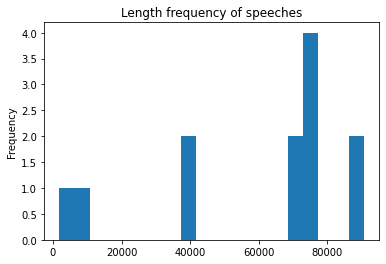

In [25]:
import matplotlib.pyplot as plt

Data['script'].apply(len).plot(bins=20, kind = 'hist')
plt.title('Length frequency of speeches')
plt.show()

We can see that there is high variability in the length of Trump's speeches. Let's compare the lengths before and after cleaning the scripts and see what are the shortest and longest speeches.

In [26]:
Data['pre_clean_len'] = [len(t) for t in Data.script]
Data.head()

,id,script,tidy_script,pre_clean_len
0,0,"\n\t\n\t\t\n\t\t\n\t\t\t\t\n\t\t\tDonald Trump: (00:13)\nHello, Iowa. Congratulations to the Iowa hawkers. That was a big win today. I’m thrilled to be back. That was a big win. But I am thrilled ...",hello iowa congratulations iowa hawkers today thrilled thrilled especially news school team tradition really amazing started keep number keep fairgrounds broke record tonight history fairgrounds h...,86955
1,1,"\n\t\n\t\t\n\t\t\n\t\t\t\t\n\t\t\tDonald Trump: (03:37)\nWe have great, great people running. Many of them are right here. I love Marjorie. With your help, we’re going to take back the House and s...",running many love marjorie help take house send nancy pelosi francisco work hard bring city helped destroy destroying nation destroying nation fire ultra left wing senator ralph warnock elect hers...,76580
2,2,\n\t\n\t\t\n\t\t\n\t\t\t\t\n\t\t\tGreg Gutfeld: (00:05)\nAll right. Why should I say a thing? Let’s just get to round two. I want to ask you a question about COVID because you had COVID and my wif...,greg gutfeld thing round question covid covid wife wife years lago still gotten vaccinated keep talking vaccinated well first kind religious thing greg gutfeld skeptical skeptical greg gutfeld ske...,6778
3,3,"\n\t\n\t\t\n\t\t\n\t\t\t\t\n\t\t\tDonald Trump: (00:00)\nAs one nation, America mourns the loss of our brave and brilliant American service members in a savage and barbaric terrorist attack in Afg...",nation america mourns loss brave brilliant american service members savage barbaric terrorist attack afghanistan noble american warriors laid lives line duty sacrifice loved racing time rescue fel...,1875
4,4,"\n\t\n\t\t\n\t\t\n\t\t\t\t\n\t\t\tDonald Trump: (08:53)\nThank you. Thank you. Wow, this is a big crowd. I’ll tell you. This goes all the way back. I wish they’d show it because they just don’t do...",crowd shall tell goes wish show goes looked television television show show fake news fake news hello alabama thrilled incredible wonderful state record number state also states numbers tell rigge...,77133


In [27]:
Data['clean_len'] = [len(t) for t in Data.tidy_script]
Data.head()

,id,script,tidy_script,pre_clean_len,clean_len
0,0,"\n\t\n\t\t\n\t\t\n\t\t\t\t\n\t\t\tDonald Trump: (00:13)\nHello, Iowa. Congratulations to the Iowa hawkers. That was a big win today. I’m thrilled to be back. That was a big win. But I am thrilled ...",hello iowa congratulations iowa hawkers today thrilled thrilled especially news school team tradition really amazing started keep number keep fairgrounds broke record tonight history fairgrounds h...,86955,37655
1,1,"\n\t\n\t\t\n\t\t\n\t\t\t\t\n\t\t\tDonald Trump: (03:37)\nWe have great, great people running. Many of them are right here. I love Marjorie. With your help, we’re going to take back the House and s...",running many love marjorie help take house send nancy pelosi francisco work hard bring city helped destroy destroying nation destroying nation fire ultra left wing senator ralph warnock elect hers...,76580,33515
2,2,\n\t\n\t\t\n\t\t\n\t\t\t\t\n\t\t\tGreg Gutfeld: (00:05)\nAll right. Why should I say a thing? Let’s just get to round two. I want to ask you a question about COVID because you had COVID and my wif...,greg gutfeld thing round question covid covid wife wife years lago still gotten vaccinated keep talking vaccinated well first kind religious thing greg gutfeld skeptical skeptical greg gutfeld ske...,6778,2836
3,3,"\n\t\n\t\t\n\t\t\n\t\t\t\t\n\t\t\tDonald Trump: (00:00)\nAs one nation, America mourns the loss of our brave and brilliant American service members in a savage and barbaric terrorist attack in Afg...",nation america mourns loss brave brilliant american service members savage barbaric terrorist attack afghanistan noble american warriors laid lives line duty sacrifice loved racing time rescue fel...,1875,1002
4,4,"\n\t\n\t\t\n\t\t\n\t\t\t\t\n\t\t\tDonald Trump: (08:53)\nThank you. Thank you. Wow, this is a big crowd. I’ll tell you. This goes all the way back. I wish they’d show it because they just don’t do...",crowd shall tell goes wish show goes looked television television show show fake news fake news hello alabama thrilled incredible wonderful state record number state also states numbers tell rigge...,77133,33274


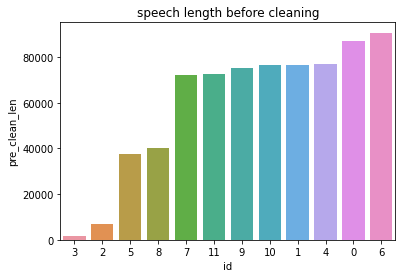

In [28]:
import seaborn as sns

sns.barplot(x='id', y='pre_clean_len', data=Data, order=Data.sort_values('pre_clean_len').id)
plt.title('speech length before cleaning')
plt.show()

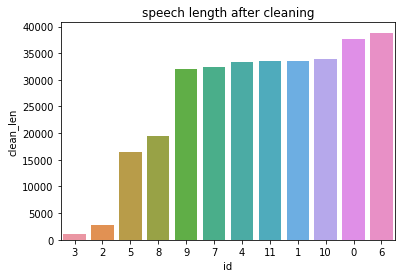

In [29]:
sns.barplot(x='id', y='clean_len', data=Data, order=Data.sort_values('clean_len').id)
plt.title('speech length after cleaning')
plt.show()

The length of the scripts have reduced a lot in most cases, sometimes more than half. Also, the order of the cleaned scripts sorted by length is different.

In [30]:
print('Shortest speech before cleaning',Data.pre_clean_len.min())
print('Longest speech before cleaning',Data.pre_clean_len.max())

Shortest speech before cleaning 1875
Longest speech before cleaning 90636


In [31]:
print('Shortest speech after cleaning',Data.clean_len.min())
print('Longest speech after cleaning',Data.clean_len.max())

Shortest speech after cleaning 1002
Longest speech after cleaning 38837


The shortest script corresponds to a speech pronounced on August 26, 2021, after a bomb exploded in Kabul Airport.

The longest script corresponds to the speech pronounced at the Arizona Rally on July 24, 2021.

We can see that we have six transcripts (half of our dataset) with very similar lengths, but the other six have very different lengths. Let's see what happens when we plot a box-plot. First we apply the describe() function to the dataset.

In [32]:
Data.describe()

,id,pre_clean_len,clean_len
count,12.000000,12.000000,12.000000
mean,5.500000,59500.833333,26230.666667
std,3.605551,30352.884176,13137.804773
min,0.000000,1875.000000,1002.000000
25%,2.750000,39567.250000,18684.500000
50%,5.500000,73970.000000,32796.000000
75%,8.250000,76718.250000,33609.000000
max,11.000000,90636.000000,38837.000000


We can see that there is a huge difference between the min and max values, and that the median (50% quartile) is higher than the mean. In this case the median is the average of the lengths of transcripts 11 and 9 and clean transcripts 7 and 4. Let's see how the boxplots look like.

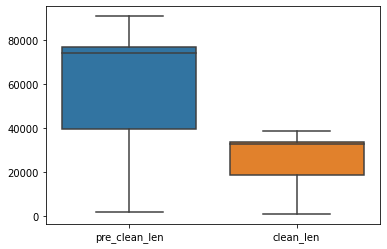

In [33]:
sns.boxplot(data=Data[['pre_clean_len', 'clean_len']])

Both boxplots are negatively skewed, that's because of the influence of the shortests transcripts, and thus can be considered outliers.

## Text Feature Analysis

Let's analyze now the contents of the scripts. This is not really necessary to prepare the data to fit the model, but it helps us to get insights and other useful information from the scripts. First we are going to plot wordclouds to see the most common words before and after cleaning the texts.

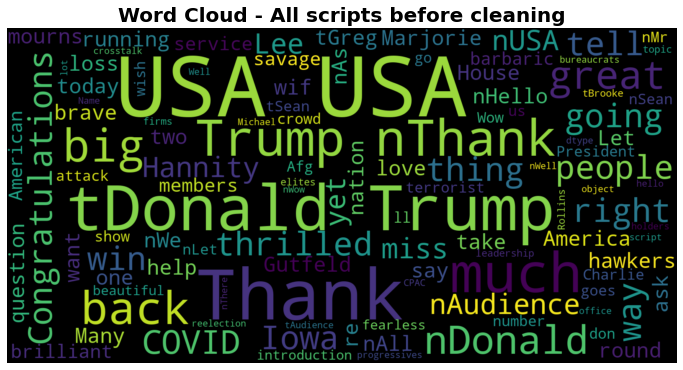

In [34]:
from wordcloud import WordCloud
wordcloud = WordCloud(width=1600, height=800,max_font_size=200).generate(str(Data['script']))
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title('Word Cloud - All scripts before cleaning',fontsize=20,fontweight='bold')
plt.show()

It looks like the most common words are 'USA', 'Donald', 'Trump' and 'Thank'. we also can see the t's and n's that are at the beginning and end of the scripts. Let's plot the wordcloud for the cleaned scripts.

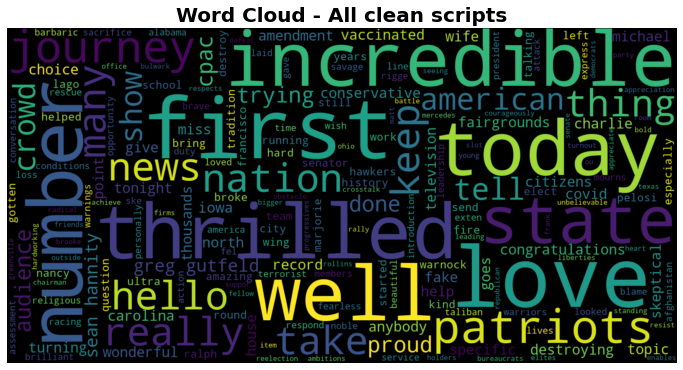

In [35]:
wordcloud = WordCloud(width=1600, height=800,max_font_size=200).generate(str(Data['tidy_script']))
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title('Word Cloud - All clean scripts',fontsize=20,fontweight='bold')
plt.show()

As we expected, this wordcloud looks completely different, since in the cleaning process we have removed the most common words and the shortest words. We can see words like 'love', 'number', 'patriots', 'first'...

# Data vectorization
Word tokenization - Word Lemmatization - BoW - TF-IDF 

In [36]:
def vectorization(data):
  tokenizer = data['tidy_script'].apply(lambda x: word_tokenize(x))
  lemma = tokenizer.apply(lambda x: ' '.join([lem.lemmatize(i) for i in x]))
  token = RegexpTokenizer(r'[a-zA-Z0-9]+')
  cv = CountVectorizer(lowercase=True,stop_words='english', ngram_range = (1,1),tokenizer = token.tokenize)
  bow = cv.fit_transform(lemma)
  text_tf= TfidfVectorizer().fit_transform(data)
  pos = []
  for item in range(len(tokenizer)):
    tag = nltk.pos_tag(tokenizer[item])
    pos.append(tag)
  return tokenizer, lemma, bow, text_tf, pos

In [37]:
tokenize, lemma, bow, text_tf, pos = vectorization(Data)

In [38]:
display(tokenize)
display(lemma)
display(bow)
display(text_tf)

0     [hello, iowa, congratulations, iowa, hawkers, today, thrilled, thrilled, especially, news, school, team, tradition, really, amazing, started, keep, number, keep, fairgrounds, broke, record, tonigh...
1     [running, many, love, marjorie, help, take, house, send, nancy, pelosi, francisco, work, hard, bring, city, helped, destroy, destroying, nation, destroying, nation, fire, ultra, left, wing, senato...
2     [greg, gutfeld, thing, round, question, covid, covid, wife, wife, years, lago, still, gotten, vaccinated, keep, talking, vaccinated, well, first, kind, religious, thing, greg, gutfeld, skeptical, ...
3     [nation, america, mourns, loss, brave, brilliant, american, service, members, savage, barbaric, terrorist, attack, afghanistan, noble, american, warriors, laid, lives, line, duty, sacrifice, loved...
4     [crowd, shall, tell, goes, wish, show, goes, looked, television, television, show, show, fake, news, fake, news, hello, alabama, thrilled, incredible, wonderful, state, r

0     hello iowa congratulation iowa hawker today thrilled thrilled especially news school team tradition really amazing started keep number keep fairground broke record tonight history fairground histo...
1     running many love marjorie help take house send nancy pelosi francisco work hard bring city helped destroy destroying nation destroying nation fire ultra left wing senator ralph warnock elect hers...
2     greg gutfeld thing round question covid covid wife wife year lago still gotten vaccinated keep talking vaccinated well first kind religious thing greg gutfeld skeptical skeptical greg gutfeld skep...
3     nation america mourns loss brave brilliant american service member savage barbaric terrorist attack afghanistan noble american warrior laid life line duty sacrifice loved racing time rescue fellow...
4     crowd shall tell go wish show go looked television television show show fake news fake news hello alabama thrilled incredible wonderful state record number state also sta

<12x4695 sparse matrix of type '<class 'numpy.int64'>'
	with 13475 stored elements in Compressed Sparse Row format>

<5x5 sparse matrix of type '<class 'numpy.float64'>'
	with 5 stored elements in Compressed Sparse Row format>